In [70]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm
import matplotlib 
import seaborn as sns
from datetime import date
from pylab import rcParams

# Exploratory Data Analysis

Read raw data from excel file and transform data if necessary.

In [5]:
# read data from xls file
ssdata = pd.read_excel('Superstore.xls')
ssdata.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [6]:
# explore data types and more
ssdata.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

We are interested the items under 'Category' variable. They are 'Furniture', 'Office Supplies', and 'Technology'. For now, we only care about 'Furniture'. 

In [58]:
set(ssdata['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

Let's dig deep into 'Furniture' to see if there are any missing values or extreme values. 

In [59]:
# create a unique name for 'Furniture' category
furniture = ssdata.loc[ssdata['Category']=='Furniture']

# check max and min time under 'Furniture' category 
# to make things easier we will use furniture to refer
# 'Furniture' category 
print('Furniture sale time period is '+str(round((furniture['Order Date'].max()- furniture['Order Date'].min()).days/365,2))+' years')

Furniture sale time period is 3.98 years


From the 'Order Date' we can infer that furniture is a time series with 4 years length. Then the next step is to explore the correlationships between 'Sales' and all other variables.

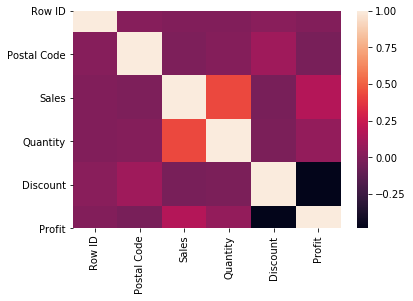

In [60]:
# we can begin with numeric varibales, if the final predictive
# model is not efficient then we can come back to check those 
# categroical variables
sns.heatmap(furniture.corr())

From the correlation heat map we can barely see significant correlationship between Sales and other variables. This is also a reason we do time series analysis since time series used past variable values to predict future variable values.

In [61]:
not_needs = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 'Segment', 'Country',
        'City', 'State', 'Postal Code', 'Region', 'Product ID',
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 
        'Discount', 'Profit']
furniture.drop(not_needs,axis=1,inplace=True)

In [62]:
# check dropping results, looks good
furniture.head(2)

,Order Date,Sales
0,2016-11-08,261.96
1,2016-11-08,731.94


In [63]:
# sort values in time order, and check null or missing values
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

No missing values are there in the cleaned data set and the EDA step is finished. Now we will move to time series analysis.

# Time series analysis

To begin time series analysis, we need first index the Order Date so that we can feed it to the time series model.

In [65]:
# indexing Order Date
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

We first use month average as input for our time series analysis since daily sales might have lots of noise in them.

In [66]:
# get monthly average sales data
sales_month = furniture['Sales'].resample('MS').mean()
sales_month.head(5)

Order Date
2014-01-01    312.126250
2014-02-01    262.808286
2014-03-01    441.635030
2014-04-01    305.570654
2014-05-01    288.032792
Freq: MS, Name: Sales, dtype: float64

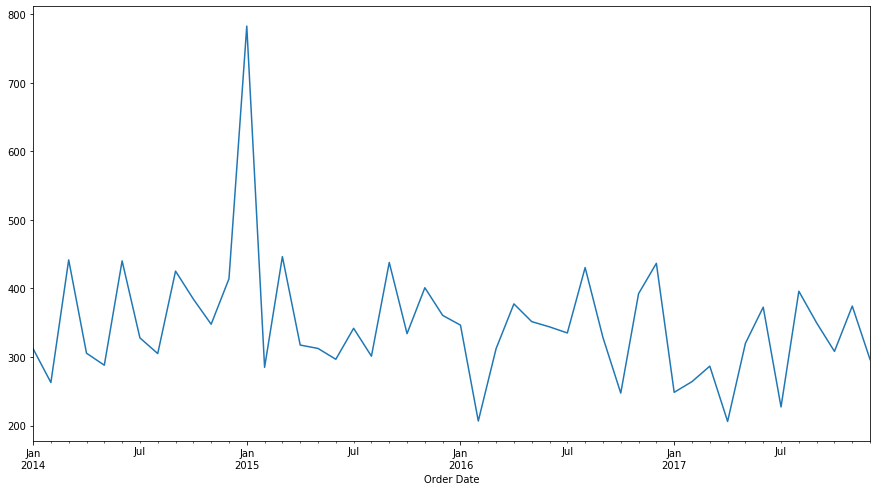

In [68]:
# plot monthly sales data
sales_month.plot(figsize=(15,8))
plt.show()

The monthly furniture sales average plot depicts seasonality in the sales dataset. The sales are always low at the end of the year and high at the mid of each season. 

To better see the patterns within the furniture sales data, we can decompose the sales data into three components: trend, seasonality, and noise.

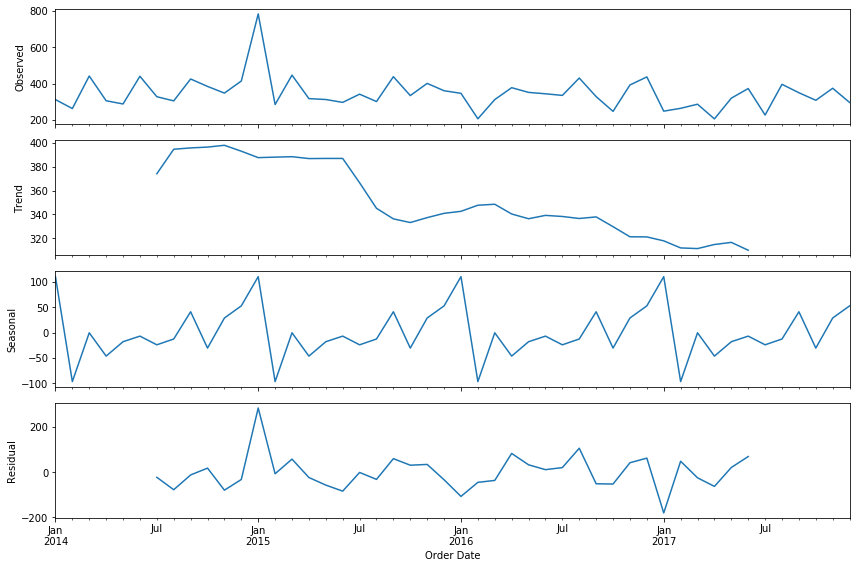

In [74]:
# decompose furniture monthly average sales into three components
# from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

decomposition = sm.tsa.seasonal_decompose(sales_month, model='additive')
decomposition.plot()
plt.show()

The above plots show that there are obvious seasonality and a down side trend.

## Time series Autoregressive Integrated Moving Average(ARIMA ) model 

FBProphet is a wonderful library in Python to do time series analysis, but for this project we will build our ARIMA model just in case we need more changes within the model.

An ARIMA model is denoted with ARIMA(p,d,q), where p, d, and q account for seasonality, trend, and noise correspondingly.

In [81]:
# we can choose a broad range for parameters if necessary 
# usually range(0,2) will satisify most of the situations
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [89]:
# model selection by choosing parameters for ARIMA model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1324.3661507188076
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.20464898591723
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:421.1756110053355
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.124068066579


C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2769.7875462923853
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364607
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1115473662885


C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:411.57840713552736
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662502366
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.6389269639644
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1296.1966120951458
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.35521367147123
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746


C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1300.2660573079893
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.11584524769427
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:538.8964721447207
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2853.9902688530165
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:412.87269899051546
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:419.1839792724945


C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:273.4032454636427
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:592.7661498749849


C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1252.859591514394
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:427.7241159738327
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:420.41145389920365
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:422.29220651941375
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:273.5840395565934
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:553.2719417804199
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3089.7987255063535
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:418.52617830891893
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:422.4003583323479
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:388.5413706209056
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:275.47757405308175
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:566.5211872508684
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1363.7299705795044
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:430.33057708179365

C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:397.3668981651521
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1068.8170935523485
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:273.44153987929343
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:540.6257368397362
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2511.949524294966
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:414.772617304297
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:391.83032555747764


C:\Users\Jinxin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2460.0839964597776
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:263.9371084381265


We choose AIC as our mertic t